# Emittance measurement along the cycle with and without RF

First of all let's see if the effect remains along the cycle

In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/PS-injection-steering/Data analysis/2018.08.22
Your IP is 172.17.0.36
2018-08-27 17:18:28
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [2]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [3]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.22'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'logical_PI_KFA45.K.value', # Kicker k parameter value (mrad)
                'PI_KFA45.AQN1.value',
                'PI_KFA45.CCV.value', 
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples',
                'PA_GSV10GLOBAL.Enable.enabled.value',
                'PAX_PLIPROG.Setting.bit4.value',
                'PA_GSRLGAIN.Enable.enabled.value',
                'PAX_SSWPROTINJ.OutEnable.outEnabled.value']



In [4]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 139 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.22/data/2018.08.22.14.45.00.875.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.22/data/2018.08.22.16.10.34.334.mat


In [5]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

In [6]:
myDataFrame['RF_on'] = (myDataFrame['PA_GSV10GLOBAL.Enable.enabled.value']==1) & (myDataFrame['PAX_PLIPROG.Setting.bit4.value']==0) & (myDataFrame['PA_GSRLGAIN.Enable.enabled.value']==1) & (myDataFrame['PAX_SSWPROTINJ.OutEnable.outEnabled.value']==1)


# Data cleanup

In [7]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

Dropped 1 duplicate(s)
---
BPM data ok
---


# Match the tomogram data

In [8]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [9]:
# new tomogram analysis
files_tomo=sorted(glob.glob(folderPath+'/tomo_data/*.dat'))

tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_003.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_005.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/20

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_047.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_048.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_049.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_050.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_051.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/20


IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_092.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_093.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_094.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_095.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_096.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/


IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_138.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_139.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_140.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_141.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_142.dat
/eos/project/l/liu/Instrumentation/tomography/runo

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_182.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_183.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_184.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_185.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_186.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_226.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_227.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_228.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_229.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle//tomo_data/C185_230.dat

IOError

/eos/project/l/liu/Instrumentation/tomog

In [21]:
timeTolerance = 18

# ---------- Vars initialisation
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
myDataFrame['beta']=np.nan
myDataFrame['gamma']=np.nan
myDataFrame['deltaP_P']=[np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['momentumProfile']=[np.empty(0,dtype=float)]*len(myDataFrame)


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]
    tomo_dpprms = tomo_data['deltaP_P_RMS'].iloc[k]
#     tomo_pkldens = tomo_data['peakLineDensity'].iloc[k]
    betar = tomo_data['beta'].iloc[k]
    gammar = tomo_data['gamma'].iloc[k]
    dpp_profil = tomo_data['deltaP_P'].iloc[k]
    p_profil = tomo_data['myProfile'].iloc[k]    


    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x]= tomo_dpprms
#             myDataFrame['peakLineDensity'].iloc[x]= tomo_pkldens
            myDataFrame['beta'].iloc[x]= betar
            myDataFrame['gamma'].iloc[x]= gammar
            myDataFrame['deltaP_P'].iloc[x]= dpp_profil
            myDataFrame['momentumProfile'].iloc[x]= p_profil


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

70/166 are within the timeTolerance
length of dataframe is: 140


In [22]:
myDataFrame[['tomoFilename','deltaP_P_rms','RF_on','PA_GSV10GLOBAL.Enable.enabled.value']].iloc[0:20]

,tomoFilename,deltaP_P_rms,RF_on,PA_GSV10GLOBAL.Enable.enabled.value
2018-08-13 12:11:12.700,<type 'str'>,NaN,True,1
2018-08-13 12:11:49.900,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,0.000861,True,1
2018-08-13 12:13:04.300,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,0.000874,True,1
2018-08-13 12:13:41.500,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,0.000865,True,1
2018-08-13 12:14:18.700,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,0.000863,False,0
2018-08-13 12:14:55.900,/eos/project/l/liu/PS/data/2017/MD2586_Injecti...,0.000856,False,0
2018-08-13 12:15:33.100,<type 'str'>,NaN,False,0
2018-08-13 12:16:10.300,<type 'str'>,NaN,False,0
2018-08-13 12:16:47.500,<type 'str'>,NaN,False,0
2018-08-13 12:17:24.700,<type 'str'>,NaN,True,1


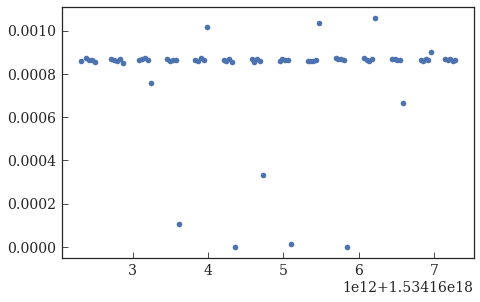

In [23]:
plt.plot(myDataFrame['deltaP_P_rms'],'o')

In [59]:
# new tomogram analysis --> RF OFF USE THE TOMOGRAMS OF THE PSB
files_tomo=sorted(glob.glob(folderPath+'tomo_data_PSB/*.dat'))

tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_001.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_002.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_003.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_004.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_005.dat

IOError

/eos/


IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_043.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_044.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_045.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_046.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_047.dat

IOEr


IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_085.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_086.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_087.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_088.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_089.dat

IOEr


IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_127.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_128.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_129.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_130.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.13/RF_on_off_along_cycle/tomo_data_PSB/autosave_131.dat

IOEr

In [ ]:
timeTolerance = 18

# ---------- Vars initialisation
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
myDataFrame['beta']=np.nan
myDataFrame['gamma']=np.nan
myDataFrame['deltaP_P']=[np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['momentumProfile']=[np.empty(0,dtype=float)]*len(myDataFrame)


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]
    tomo_dpprms = tomo_data['deltaP_P_RMS'].iloc[k]
#     tomo_pkldens = tomo_data['peakLineDensity'].iloc[k]
    betar = tomo_data['beta'].iloc[k]
    gammar = tomo_data['gamma'].iloc[k]
    dpp_profil = tomo_data['deltaP_P'].iloc[k]
    p_profil = tomo_data['myProfile'].iloc[k]    


    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x]= tomo_dpprms
#             myDataFrame['peakLineDensity'].iloc[x]= tomo_pkldens
            myDataFrame['beta'].iloc[x]= betar
            myDataFrame['gamma'].iloc[x]= gammar
            myDataFrame['deltaP_P'].iloc[x]= dpp_profil
            myDataFrame['momentumProfile'].iloc[x]= p_profil


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

In [24]:
#stupid solution to the momentary problem with the PSB tomograms
myDataFrame['deltaP_P_rms'].loc[np.isnan(myDataFrame['tomoDelta'])] = 0.98e-3
myDataFrame['gamma'].loc[np.isnan(myDataFrame['tomoDelta'])] = myDataFrame['gamma'].iloc[1]
myDataFrame['beta'].loc[np.isnan(myDataFrame['tomoDelta'])] = myDataFrame['beta'].iloc[1]
myDataFrame['tomoDelta'].loc[np.isnan(myDataFrame['tomoDelta'])] = -1

In [26]:
# discard the elements without tomogram
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
# myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

In [17]:
myDataFrame['beta'].iloc[1]

0.91513870718823453

# Temporary fix of the tomogram matching

In [40]:
myDataFrame['gamma'] = 2.4805332974656586
myDataFrame['beta'] = 0.91513870718823453
myDataFrame['deltaP_P_rms'] = np.nan
myDataFrame['deltaP_P_rms'].loc[myDataFrame['RF_on']==True] = 0.89e-3
myDataFrame['deltaP_P_rms'].loc[myDataFrame['RF_on']==False] = 0.98e-3


# Save the imported data

In [41]:
myDataFrame.to_pickle('imported_data_2018.08.22.pkl')

In [5]:
# myDataFrame=pnd.read_pickle('imported_data_2018.08.22.pkl')

# Intensity

In [6]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][85]/np.max(x) )

Text(0,0.5,u'Losses')

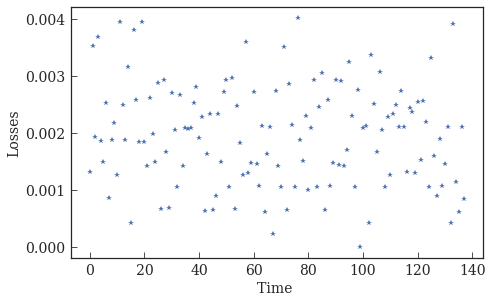

In [7]:
plt.plot(np.linspace(0,len(myDataFrame)-1,len(myDataFrame)),myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

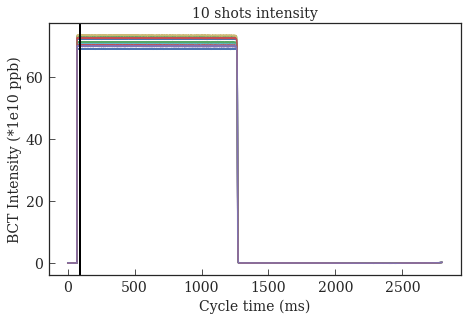

In [8]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=90, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner emittance
## X plane
### Traditional method

In [9]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
#     myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=0.98e-3)

    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

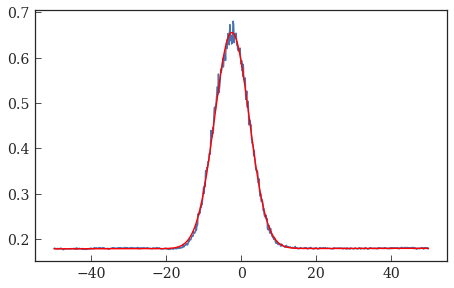

In [11]:
# manual check
k=100

plt.plot(pos , myDataFrame['BWS65_data'].iloc[k])
plt.plot(pos, myToolbox.gaussian_5_parameters(pos,*myDataFrame['WS_fit_results_x'].iloc[k][0]),'r')

## Y plane

In [12]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [13]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Calculate average emittance per measurement point

In [14]:
ctime_scan = np.linspace(185,305,13)

emix_mean = np.empty(len(ctime_scan),dtype=float)
emiy_mean = np.empty(len(ctime_scan),dtype=float)
emix_std = np.empty(len(ctime_scan),dtype=float)
emiy_std = np.empty(len(ctime_scan),dtype=float)

emix_mean_off = np.empty(len(ctime_scan),dtype=float)
emiy_mean_off = np.empty(len(ctime_scan),dtype=float)
emix_std_off = np.empty(len(ctime_scan),dtype=float)
emiy_std_off = np.empty(len(ctime_scan),dtype=float)


for k, ctime in enumerate(ctime_scan):
    emix_mean[k] = np.mean(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==True)])
    emiy_mean[k] = np.mean(myDataFrame['WS_emittance_y'].loc[(myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==True)])
    emix_std[k] = np.std(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==True)])
    emiy_std[k] = np.std(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==True)])
    emix_mean_off[k] = np.mean(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==False)])
    emiy_mean_off[k] = np.mean(myDataFrame['WS_emittance_y'].loc[(myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==False)])
    emix_std_off[k] = np.std(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==False)])
    emiy_std_off[k] = np.std(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==False)])


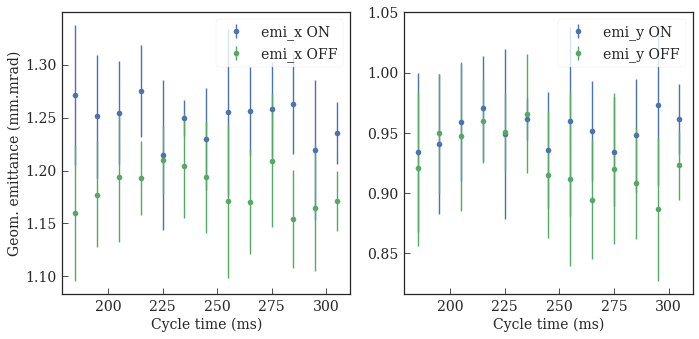

In [15]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].errorbar(ctime_scan, emix_mean, yerr=emix_std, fmt='o',label='emi_x ON')
ax[0].errorbar(ctime_scan, emix_mean_off, yerr=emix_std_off, fmt='o',label='emi_x OFF')

ax[1].errorbar(ctime_scan, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y ON')
ax[1].errorbar(ctime_scan, emiy_mean_off, yerr=emiy_std_off, fmt='o',label='emi_y OFF')


ax[0].set_xlabel('Cycle time (ms)')
ax[0].set_ylabel('Geom. emittance (mm.mrad)')
ax[1].set_xlabel('Cycle time (ms)')

# set axis to get rid of some bad shots
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,4,6.2))



ax[0].legend(frameon=True)
ax[1].legend(frameon=True)
fig.tight_layout()

fig.savefig('emix_y_along_cycle_geom.eps', format='eps',dpi=100)

# Laslett tune shift calculation

In [32]:
myDataFrame['peakLineDensity'] = 0.6

In [33]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [34]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

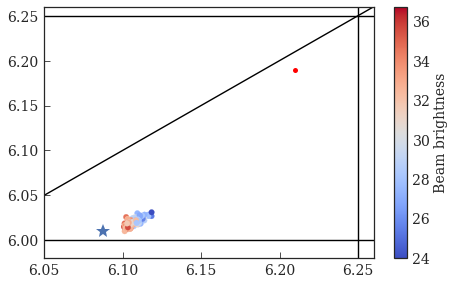

In [35]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.21
Qy = 6.19
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.05, 6.26])
plt.ylim([5.98, 6.26])
# tune shifts
p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.6, 0.9e-3,
              1e-6*0.984, 1e-6*0.843,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')

## Save the data

In [36]:
myDataFrame.to_pickle('analised_nominal_RF_off.pkl')

In [37]:
np.savetxt('emi_nominal_RFoff.txt',np.array([k_values, emix_mean, emix_std, emiy_mean, emiy_std]).T)